In [2]:
# Common imports y set up de cada notebook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import statsmodels.api as sm
from datetime import datetime
import time
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator

# Para imprimir objetos grandes
#np.set_printoptions(threshold = np.inf)

# Para mantener los resultados constantes al ejecutar
np.random.seed(42) # Un random.seed constante

# Para graficar figuras bonitas
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rcParams["figure.figsize"] = (12,6.75)
mpl.rcParams["axes.grid"] = False


# Guardar/importar imágenes

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Guardar/importar datos
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

# Guardar datasets
DATASETS = os.path.join(PROJECT_ROOT_DIR, "datasets")
os.makedirs(DATASETS, exist_ok=True)

In [12]:
def plot_real_vs_predicted(Y_real, Y_predicted, x_limits = (0,-1), savefig = False,
                           figname = "figure", formato = "png"):
    
    name = figname + "." + formato
    
    plt.figure(figsize = (12.8,7.2))
    
    y_limits = (Y_real.min(), Y_real.max())
    plt.ylim(y_limits)
    
    plt.plot(Y_real[x_limits[0]:x_limits[-1]], color = "black", linestyle = "-", linewidth=2, label="Real"), # color = "darkorange",
    plt.plot(Y_predicted[x_limits[0]:x_limits[-1]], "r-.", linewidth=2, label="Predicted")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Time (1 h)", fontsize=14) 
    plt.ylabel("Comsumption", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize = (12, 6.75))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("epoch")
    plt.ylabel("mse")
    plt.grid(True)
    plt.show() 

def plot_train_vs_val(train_errors, val_errors, savefig = False, 
                            figname = "figure", formato = "png"):
        
    name = figname + "." + formato
    
    plt.figure(figsize = (12,6.75))

    y_limits = (np.min([train_errors.min(), val_errors.min()]), np.max([train_errors.max(), val_errors.max()]))
    plt.ylim(y_limits)
        
    plt.plot(train_errors,  "b-.", linewidth=2, label="Training"), # color = "darkorange",
    plt.plot(val_errors, "r-.", linewidth=2, label="Validation")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("mse", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 

In [5]:
df_train = pd.read_csv(os.path.join(DATASETS, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DATASETS, "df_test.csv"))

formato = '%Y-%m-%d %H'

df_train['Datetime'] = pd.to_datetime(df_train["Datetime"], format=formato, utc = True)
df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))
df_train.drop(["Datetime"], axis = "columns", inplace = True)

df_test['Datetime'] = pd.to_datetime(df_test["Datetime"], format=formato, utc = True)
df_test = df_test.set_index(pd.DatetimeIndex(df_test['Datetime']))
df_test.drop(["Datetime"], axis = "columns", inplace = True)

useful_features = df_train.columns.to_list()
print(df_train.shape, df_train.columns, "\n")
print(df_test.shape, df_test.columns, "\n")
print(df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max())

(28051, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y + 11',
       'y + 12', 'y + 13', 'y + 14', 'y + 15', 'y + 16', 'y + 17', 'y + 18',
       'y + 19', 'y + 20', 'y + 21', 'y + 22', 'y + 23', 'y + 24'],
      dtype='object') 

(7013, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y +

In [6]:
# Selecciono las columnas para one step forecasting

df_train = df_train.iloc[:,:-23].dropna()
df_test = df_test.iloc[:,:-23].dropna()

X_Y_train = df_train.to_numpy()

X_Y_test = df_test.to_numpy()
X_test = X_Y_test[:,:-1]
Y_test = X_Y_test[:,-1]


# Hago la división en train y val

from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Hacer train_test_split con shuffle = False y random_state = cte sirve para dividir time series

X_train, X_val, Y_train, Y_val = train_test_split(X_Y_train[:,:-1], X_Y_train[:,-1],
                                                  test_size = 0.25, random_state = 42, shuffle = False)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

#  --> Ahora, incluyo el análisis exporatorio hecho en el X_train, Y_train únicamente !!!


# Escalo la data a un rango [0, 1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_Y_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis = 1)
#X_Y_train = np.concatenate([X_train, np.expand_dims(Y_train, axis=1)], axis = 1)
X_Y_train = scaler.fit_transform(X_Y_train)

X_Y_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(Y_val)], axis = 1)
#X_Y_val = np.concatenate([X_val, np.expand_dims(Y_val, axis=1)], axis = 1)
X_Y_val = scaler.transform(X_Y_val)

X_Y_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(Y_test)], axis = 1)
#X_Y_test = np.concatenate([X_test, np.expand_dims(Y_test, axis=1)], axis = 1)
X_Y_test = scaler.transform(X_Y_test)


X_train = X_Y_train[:,:-1]
Y_train = X_Y_train[:,-1]

X_val = X_Y_val[:,:-1]
Y_val = X_Y_val[:,-1]

X_test = X_Y_test[:,:-1]
Y_test = X_Y_test[:,-1]

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

print(X_train[0], Y_train[0], X_val[0], Y_val[0]) # Compruebo que está estandarizdo

(21037, 14) (21037,) (7013, 14) (7013,) (7012, 14) (7012,)
[0.44065198 0.36477505 1.         0.19080256 0.54194047 0.00691683
 0.17962843 0.         1.         0.18833984 1.         0.74444444
 1.         0.31966571] 0.2760076608339863 [0.5795207  0.37070102 0.52173913 0.         0.48115578 0.76621131
 0.27894794 0.         0.         0.24653229 0.         0.41111111
 0.57       0.64203012] 0.6081657525898843


In [7]:
# Modelos de base & tabla de errores

# mi modelo de base va a ser naive forecasting. "El consumo de ahora es el mismo que el del instante anterior"

# función auxiliar

def baseline_model_1(samples, previous_sample=1): # cualquier instante anterior
    
    # Samples es un dataframe con los targets
    # previous_sample es la muestra anterior que queremos que se devuelva
    
    df = pd.DataFrame(data = samples, columns = ["real"])
    if previous_sample > samples.size:
        return ("No hay instantes anteriores a t-"+str(previous_sample))
    
    df["naive_1h"] = df["real"].shift(previous_sample)
    
    return df.dropna()


# Creo la predicción del modelo naive en los tres sets

# train, val, test

naive_train = baseline_model_1(Y_train, previous_sample=1)
naive_val = baseline_model_1(Y_val, previous_sample=1)
naive_test = baseline_model_1(Y_test, previous_sample=1)

# creo un dataframe para guardar los errores
from sklearn.metrics import mean_squared_error

errores_df = pd.DataFrame()

errores_df.loc["naive_1h", "train mse"] = mean_squared_error(naive_train.iloc[:,0], naive_train.iloc[:,-1])
errores_df.loc["naive_1h", "val mse"] = mean_squared_error(naive_val.iloc[:,0], naive_val.iloc[:,-1])
errores_df.loc["naive_1h", "delta errores"] = np.abs(errores_df.loc["naive_1h", "train mse"]-errores_df.loc["naive_1h", "val mse"])
errores_df.loc["naive_1h", "n params"] = 0
errores_df.loc["naive_1h", "training time (s)"] = np.nan
errores_df.loc["naive_1h", "training prediction time (s)"] = np.nan
errores_df.loc["naive_1h", "validation prediction time (s)"] = np.nan

pd.options.display.float_format = '{:.2e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")
errores_df.sort_values(by = ["val mse"])

,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
naive_1h,3.97e-03,3.77e-03,1.98e-04,0.00e+00,nan,nan,nan


Pruebo un modelo para comprobar el overfitting

In [63]:
# Actualizo esta función para multitarget forecasting

def ts_learning_curves(model, X_train, Y_train, X_val, Y_val, batch = 1):
    
    # Esta función ENTRENA un modelo de ML y muestra sus Learning curves.
        
    train_errors, val_errors = [], []
    print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
    
    start_time = time.time()
    
    iteraciones = Y_train.shape[0]
    
    for i in range(0, iteraciones, batch):
            
        X_train_slice, Y_train_slice = X_train[:i+1], Y_train[:i+1]
        
        model.fit(X_train_slice, Y_train_slice)
            
        Y_train_slice_predicted = model.predict(X_train_slice)
        Y_val_predicted = model.predict(X_val)
        
        train_errors.append(mean_squared_error(Y_train_slice, Y_train_slice_predicted))
        val_errors.append(mean_squared_error(Y_val, Y_val_predicted))
            
        current_time = time.time()
    
        if i%100 == 0: # Notificación para ver cuánto tiempo de entrenamiento lleva, y cuánto queda.
            print("training: "+str(i)+" of "+str(iteraciones), "current time: "+str(current_time - start_time) + " s")

    execution_time = time.time() - start_time
    
    if batch > 1:
        
        
        X_train_slice, Y_train_slice = X_train[:], Y_train[:]
        
        model.fit(X_train_slice, Y_train_slice)
            
        Y_train_slice_predicted = model.predict(X_train_slice)
        Y_val_predicted = model.predict(X_val)
        
        train_errors.append(mean_squared_error(Y_train_slice, Y_train_slice_predicted))
        val_errors.append(mean_squared_error(Y_val, Y_val_predicted))
        
        current_time = time.time()
        
        print("last training!", "current time: " +str(current_time - start_time) + " s")

    execution_time = time.time() - start_time
        

    print("tiempo de ejecución: "+str(execution_time)+" s")
    
    history = pd.DataFrame()
    history["loss"] = train_errors
    history["val_loss"] = val_errors
    
    return history

In [8]:
from sklearn.linear_model import LinearRegression

In [64]:
lr = LinearRegression(n_jobs = -1)

In [65]:
history_lr = ts_learning_curves(lr, X_train, Y_train, X_val, Y_val, batch = 16)

(21037, 14) (21037,) (7013, 14) (7013,)
training: 0 of 21037 current time: 0.006877899169921875 s
training: 400 of 21037 current time: 0.06732797622680664 s
training: 800 of 21037 current time: 0.14166736602783203 s
training: 1200 of 21037 current time: 0.2169184684753418 s
training: 1600 of 21037 current time: 0.2946000099182129 s
training: 2000 of 21037 current time: 0.3760945796966553 s
training: 2400 of 21037 current time: 0.46514391899108887 s
training: 2800 of 21037 current time: 0.5589678287506104 s
training: 3200 of 21037 current time: 0.6616570949554443 s
training: 3600 of 21037 current time: 0.7994356155395508 s
training: 4000 of 21037 current time: 0.9323556423187256 s
training: 4400 of 21037 current time: 1.0643255710601807 s
training: 4800 of 21037 current time: 1.2234117984771729 s
training: 5200 of 21037 current time: 1.3672263622283936 s
training: 5600 of 21037 current time: 1.5552327632904053 s
training: 6000 of 21037 current time: 1.803060531616211 s
training: 6400 of

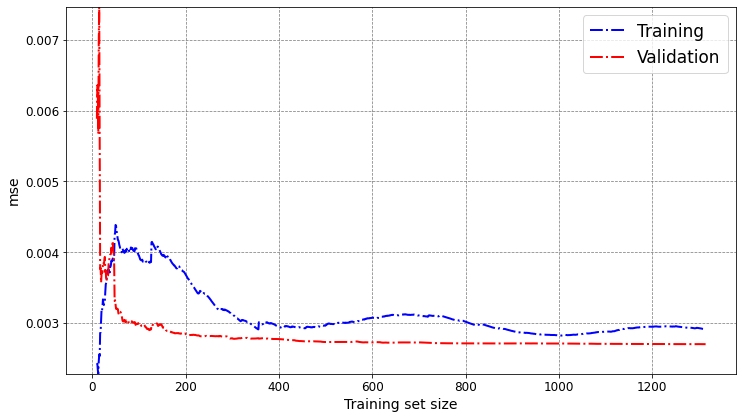

In [69]:
a = 10
b = -1
plot_train_vs_val(history_lr.iloc[a:b,0], history_lr.iloc[a:b,-1], savefig = False, 
                            figname = "figure", formato = "png")

In [75]:
lr2 = LinearRegression(n_jobs = -1)

In [ ]:
history_lr2 = ts_learning_curves(lr2, X_train, Y_train, X_val, Y_val, batch = 1)

(21037, 14) (21037,) (7013, 14) (7013,)
training: 0 of 21037 current time: 0.00838470458984375 s
training: 100 of 21037 current time: 0.24188971519470215 s
training: 200 of 21037 current time: 0.48271918296813965 s
training: 300 of 21037 current time: 0.7319715023040771 s
training: 400 of 21037 current time: 0.9902899265289307 s
training: 500 of 21037 current time: 1.2520267963409424 s
training: 600 of 21037 current time: 1.5183026790618896 s
training: 700 of 21037 current time: 1.8854553699493408 s
training: 800 of 21037 current time: 2.302515983581543 s
training: 900 of 21037 current time: 2.7738399505615234 s
training: 1000 of 21037 current time: 3.2775931358337402 s
training: 1100 of 21037 current time: 3.7757840156555176 s
training: 1200 of 21037 current time: 4.122277021408081 s
training: 1300 of 21037 current time: 4.5624964237213135 s
training: 1400 of 21037 current time: 5.157841444015503 s
training: 1500 of 21037 current time: 5.567168235778809 s
training: 1600 of 21037 curre

In [ ]:
a = 10
b = -1
plot_train_vs_val(history_lr2.iloc[a:b,0], history_lr2.iloc[a:b,-1], savefig = False, 
                            figname = "figure", formato = "png")

In [ ]:
history_lr.iloc[-1,:], history_lr2.iloc[-1,:]